# Models

### Imports

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import yaml

### Download and extract the models

In [30]:
model_folders = "model2024/ConvNextBase_species model2024/ConvNextBase_taxonomy model2023/ConvNextBase model2023/EfficientNetV2"

In [ ]:
!"./model_download.sh" "$model_folders"

### Load model and labels

In [21]:
model_folder = "model2024/ConvNextBase_species"

In [22]:
model = tf.keras.models.load_model(model_folder)

In [23]:
model.summary()

Model: "ConvNextBase_species"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 species (Dense)             (None, 89)                91225     
                                                                 
Total params: 87,657,689
Trainable params: 87,657,689
Non-trainable params: 0
_________________________________________________________________


In [24]:
with open("labels.yaml") as f:
    labels = yaml.load(f, yaml.SafeLoader)

### Run predictions on a single image

In [25]:
def load_and_crop_image(metadata, image_shape=[224,224]):
    """
    Loads an image from metadata and crops it to it's bounding box
    :param metadata: the image metadata
    :return: the cropped image
    """

    img = tf.io.read_file(metadata['file'])
    img = tf.io.decode_image(img, channels=3)
    img = tf.cast(img, tf.float32)

    if len(metadata['bbox']) == 0:
        bbox = [0.0, 0.0, 1.0, 1.0]
    else:
        bbox = metadata['bbox']
        bbox = [bbox[1], bbox[0], bbox[1]+bbox[3], bbox[0]+bbox[2]]

    cropped_img = tf.image.crop_and_resize([img], [bbox], [0], image_shape, method='bilinear')

    return cropped_img

In [26]:
def predict_and_decode(img, model, labels, top_k = None):
    """
    Performs model predictions on a given cropped image and returns the decoded top predictions
    :param img: the cropped image to run predictions
    :param model: the model to perform predictions with
    :param labels: the labels to decode the predictions
    :param top_k: if given return the top k predictions instead of the top prediction only
    :return: the decoded top predictions
    """
    
    preds = model.predict(img)
    preds_decoded = {}
    
    for pred_class, pred in preds.items():
        if top_k is not None:
            k = min(pred[0].shape[0], top_k)
            top_k_pred = tf.math.top_k(pred[0], k=k)
            preds_decoded[pred_class] = [(labels[pred_class][top_k_pred.indices.numpy()[t]],
                                         top_k_pred.values.numpy()[t]) for t in range(k)]
        else:
            preds_decoded[pred_class] = labels[pred_class][tf.math.argmax(pred[0]).numpy()]
    return preds_decoded

In [34]:
# taken from the first entry of `md/species/Sus_scrofa.yaml`
metadata = {
    "file": "../data/MOF/img/20211118/02/IMAG0080.JPG",
    "bbox": [0.0871, 0.4609, 0.3328, 0.4593],
}
img = load_and_crop_image(metadata)

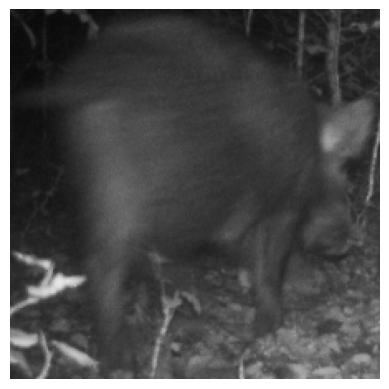

In [35]:
plt.imshow(img.numpy()[0]/255,)
plt.axis('off')
plt.show()

In [29]:
predict_and_decode(img, model, labels, top_k=5)

1/1 [==============================] - 6s 6s/step


{'species': [('Sus_scrofa', 0.9941848),
  ('Vulpes_vulpes', 0.0032548888),
  ('Meles_meles', 0.0005167092),
  ('Capreolus_capreolus', 0.00046460962),
  ('Empty', 0.00021948802)]}